In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 540 files [00:00, 626.11 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
2 folder and 0 images in output\test
0 folder and 11 images in output\test\Normal
0 folder and 17 images in output\test\Tuberculosis
2 folder and 0 images in output\train
0 folder and 162 images in output\train\Normal
0 folder and 243 images in output\train\Tuberculosis
2 folder and 0 images in output\val
0 folder and 43 images in output\val\Normal
0 folder and 64 images in output\val\Tuberculosis


In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (512, 512, 3)


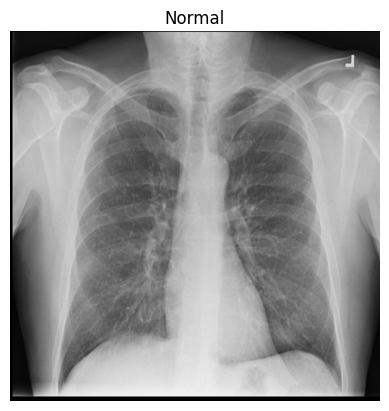

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Normal')

Image Shape : (512, 512)


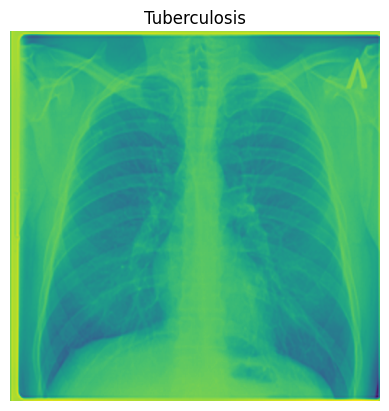

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Tuberculosis')

In [9]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [10]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.


In [11]:
train_data.class_indices

{'Normal': 0, 'Tuberculosis': 1}

In [12]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [13]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (405,)
val_y.shape:  (107,)
test_y.shape:  (28,)


In [14]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [15]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(2)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,050 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,039,554 (26.85 MB)

 Trainable params: 2,050 (8.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [17]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [18]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=10, validation_data=valid_data)

Epoch 1/10


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 6s/step - accuracy: 0.5096 - loss: 0.9540 - val_accuracy: 0.5047 - val_loss: 0.7429
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - accuracy: 0.5261 - loss: 0.7395 - val_accuracy: 0.7103 - val_loss: 0.6086
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.6632 - loss: 0.6163 - val_accuracy: 0.6822 - val_loss: 0.5747
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 45s 6s/step - accuracy: 0.7662 - loss: 0.5285 - val_accuracy: 0.8879 - val_loss: 0.4547
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 41s 5s/step - accuracy: 0.8087 - loss: 0.4690 - val_accuracy: 0.8505 - val_loss: 0.4255
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 39s 5s/step - accuracy: 0.8326 - loss: 0.4027 - val_accuracy: 0.8692 - val_loss: 0.3693
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 49s 6s/step - accuracy: 0.8538 - loss: 0.3736 - val_accuracy: 0.8692 - val_loss: 0.3564
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 55s 7s/step - accuracy: 0.8829 - loss: 0.3487 - val_accuracy: 0.8692 - val_loss: 0.3328
Epoch 9/10
7/7 ━━━━

In [19]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

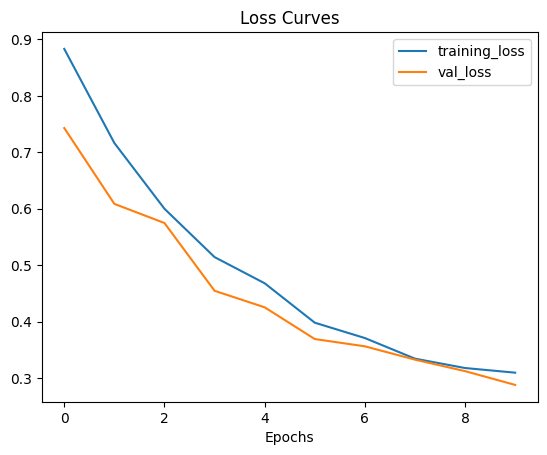

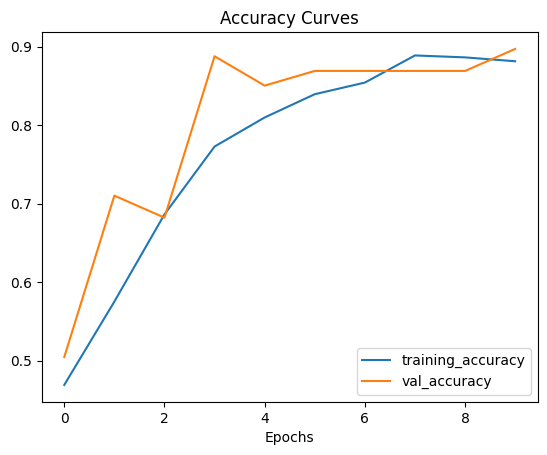

In [20]:
plot_loss_curves(history)

In [21]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

2/2 ━━━━━━━━━━━━━━━━━━━━ 14s 7s/step
              precision    recall  f1-score   support

           0       0.91      0.85      0.88        46
           1       0.89      0.93      0.91        61

    accuracy                           0.90       107
   macro avg       0.90      0.89      0.89       107
weighted avg       0.90      0.90      0.90       107



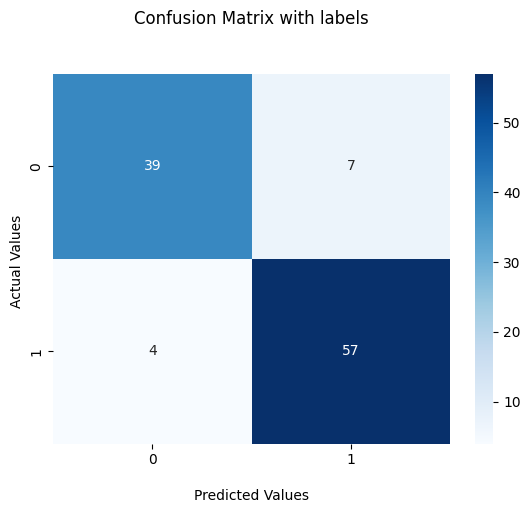

In [22]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [23]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
              precision    recall  f1-score   support

           0       0.91      0.91      0.91        11
           1       0.94      0.94      0.94        17

    accuracy                           0.93        28
   macro avg       0.93      0.93      0.93        28
weighted avg       0.93      0.93      0.93        28



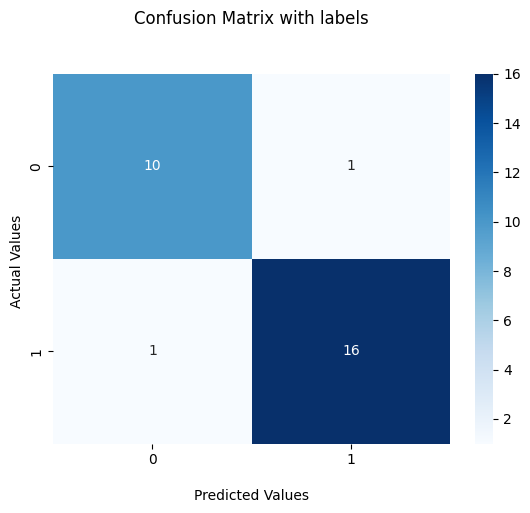

In [24]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
model.save('my_model.keras')

In [26]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Class: Tuberculosis


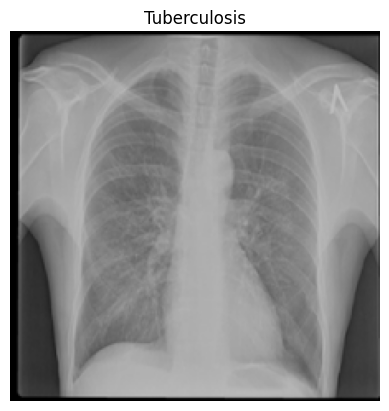

In [27]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-18.png"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Normal', 'Tuberculosis']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Print the predicted class
print("Predicted Class:", predicted_class)

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()


In [28]:

import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os


# data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'
# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# Function to create a model using a pre-trained base
def create_model(base_model_name):
    if base_model_name == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid base model name. Choose 'VGG16' or 'ResNet50'.")
    
    base_model.trainable = False  # Freeze the pre-trained layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Train and save the VGG16 model
vgg16_model = create_model("VGG16")
vgg16_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                    loss='categorical_crossentropy',
                    metrics=['accuracy'])

print("Training VGG16 Model...")
vgg16_model.fit(train_data, epochs=10, validation_data=val_data)
vgg16_model.save("vgg16_model.h5")
print("VGG16 Model saved as 'vgg16_model.h5'.")

# Train and save the ResNet50 model
resnet50_model = create_model("ResNet50")
resnet50_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

print("Training ResNet50 Model...")
resnet50_model.fit(train_data, epochs=10, validation_data=val_data)
resnet50_model.save("resnet50_model.h5")
print("ResNet50 Model saved as 'resnet50_model.h5'.")


Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Training VGG16 Model...
Epoch 1/10


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 132s 10s/step - accuracy: 0.5725 - loss: 0.7581 - val_accuracy: 0.7757 - val_loss: 0.5045
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 118s 9s/step - accuracy: 0.7136 - loss: 0.5367 - val_accuracy: 0.9065 - val_loss: 0.3662
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.8406 - loss: 0.4078 - val_accuracy: 0.8785 - val_loss: 0.3308
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 104s 8s/step - accuracy: 0.8656 - loss: 0.3567 - val_accuracy: 0.9065 - val_loss: 0.2773
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 111s 9s/step - accuracy: 0.8790 - loss: 0.3091 - val_accuracy: 0.9065 - val_loss: 0.2557
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 107s 8s/step - accuracy: 0.8748 - loss: 0.3158 - val_accuracy: 0.9252 - val_loss: 0.2441
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 108s 8s/step - accuracy: 0.8959 - loss: 0.2622 - val_accuracy: 0.9159 - val_loss: 0.2243
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 95s 7s/step - accuracy: 0.9347 - loss: 0.2293 - val_accuracy: 0.9159 - val_loss: 0.

VGG16 Model saved as 'vgg16_model.h5'.
Training ResNet50 Model...
Epoch 1/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 49s 3s/step - accuracy: 0.5366 - loss: 0.8416 - val_accuracy: 0.5981 - val_loss: 0.8530
Epoch 2/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5925 - loss: 0.8049 - val_accuracy: 0.5981 - val_loss: 0.6609
Epoch 3/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6084 - loss: 0.7101 - val_accuracy: 0.5981 - val_loss: 0.6387
Epoch 4/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 33s 2s/step - accuracy: 0.6191 - loss: 0.6501 - val_accuracy: 0.5421 - val_loss: 0.6838
Epoch 5/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 34s 3s/step - accuracy: 0.5430 - loss: 0.6964 - val_accuracy: 0.5888 - val_loss: 0.6708
Epoch 6/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step - accuracy: 0.5179 - loss: 0.6868 - val_accuracy: 0.5981 - val_loss: 0.6810
Epoch 7/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - accuracy: 0.5976 - loss: 0.6807 - val_accuracy: 0.6262 - val_loss: 0.6427
Epoch 8/10
13/13 ━━━━━━━━━━━━━━━━━━━━ 40s 3s/step - 

ResNet50 Model saved as 'resnet50_model.h5'.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Paths to training, validation, and testing directories
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

# Image dimensions and batch size
input_shape = (224, 224, 3)
batch_size = 32

# Data generators
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
val_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
val_data = val_datagen.flow_from_directory(val_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# Function to create a model using a pre-trained base
def create_model(base_model_name):
    if base_model_name == "VGG16":
        base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "VGG19":
        base_model = VGG19(weights='imagenet', include_top=False, input_shape=input_shape)
    elif base_model_name == "ResNet50":
        base_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
    else:
        raise ValueError("Invalid base model name. Choose 'VGG16', 'VGG19', or 'ResNet50'.")
    
    base_model.trainable = False  # Freeze the pre-trained layers
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(train_data.num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Function to train and save a model
def train_and_save_model(base_model_name, model_filename):
    model = create_model(base_model_name)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    print(f"Training {base_model_name} Model...")
    model.fit(train_data, epochs=15, validation_data=val_data)
    model.save(model_filename)
    print(f"{base_model_name} Model saved as '{model_filename}'.")

# Train and save the models
train_and_save_model("VGG16", "vgg16_model.h5")
train_and_save_model("VGG19", "vgg19_model.h5")
train_and_save_model("ResNet50", "resnet50_model.h5")


Found 405 images belonging to 2 classes.
Found 107 images belonging to 2 classes.
Found 28 images belonging to 2 classes.
Training VGG16 Model...
Epoch 1/15
12/13 [==========================>...] - ETA: 3s - loss: 0.6299 - accuracy: 0.6542

Available Models: ['VGG16', 'VGG19', 'ResNet50', 'DenseNet']


Enter the model name to use for prediction (VGG16, VGG19, ResNet50, DenseNet):  VGG16


1/1 [==============================] - 0s 344ms/step


C:\Users\Ajay\AppData\Local\Temp\ipykernel_5536\1462599738.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


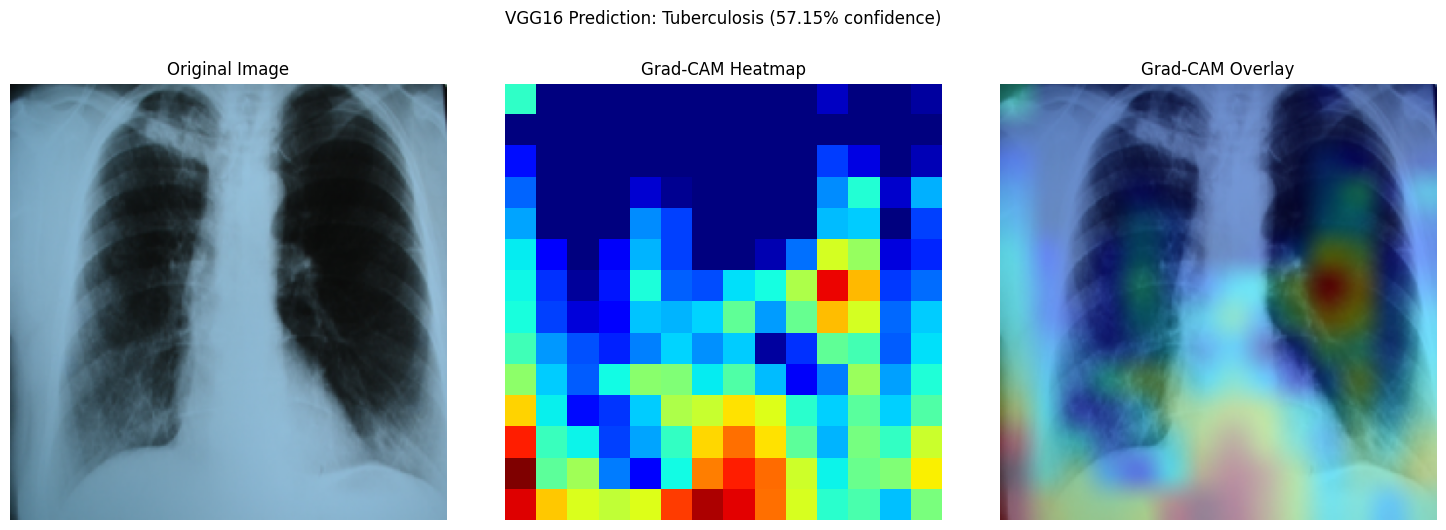

In [4]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import tensorflow as tf
import cv2

# Define the list of models and their respective file paths
models = {
    "VGG16": "vgg16_model.h5",
    "VGG19": "vgg19_model.h5",
    "ResNet50": "resnet50_model.h5",
    "DenseNet": "densenet_model.keras"
}
def load_selected_model(model_name):
    """
    Load the selected deep learning model.
    """
    if model_name not in models:
        raise ValueError(f"Invalid model name: {model_name}. Choose from {list(models.keys())}")

    model_path = models[model_name]
    return load_model(model_path)


def get_last_conv_layer(model_name, model):
    """
    Get the name of the last convolutional layer based on the model architecture
    """
    last_conv_layer = None
    
    if model_name in ["VGG16", "VGG19"]:
        for layer in reversed(model.layers):
            if 'conv' in layer.name:
                last_conv_layer = layer.name
                break
    elif model_name == "ResNet50":
        last_conv_layer = "conv5_block3_out"
    elif model_name == "DenseNet":
        for layer in reversed(model.layers):
            if 'conv' in layer.name:
                last_conv_layer = layer.name
                break
    
    return last_conv_layer

def generate_gradcam(model, img_array, last_conv_layer, pred_index=None):
    """
    Generate Grad-CAM heatmap
    """
    # First, we create a model that maps the input image to the activations
    # of the last conv layer and output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the predicted class
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.maximum(tf.reduce_max(heatmap), 1e-10)
    heatmap = heatmap.numpy()

    return heatmap

def create_gradcam_overlay(img_array, heatmap):
    """
    Create a superimposed visualization of the Grad-CAM heatmap on the original image
    """
    # Rescale heatmap to 0-255
    heatmap = np.uint8(255 * heatmap)
    
    # Use jet colormap to colorize heatmap
    jet = plt.cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img_array.shape[2], img_array.shape[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    original_img = img_array[0] * 255
    superimposed_img = jet_heatmap * 0.4 + original_img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

def predict_with_model(model_name, class_names):
    """
    Predict and visualize results with Grad-CAM
    """
    # Load model
    model = load_selected_model(model_name)
    
    # Get predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100
    
    # Get last convolutional layer name
    last_conv_layer = get_last_conv_layer(model_name, model)
    
    if last_conv_layer is None:
        raise ValueError(f"Could not find the last convolutional layer for {model_name}")
    
    # Generate Grad-CAM heatmap
    heatmap = generate_gradcam(model, img_array, last_conv_layer)
    
    # Create superimposed visualization
    superimposed_img = create_gradcam_overlay(img_array, heatmap)
    
    # Create figure with subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax1.imshow(img_array[0])
    ax1.set_title('Original Image')
    ax1.axis('off')
    
    # Heatmap
    ax2.imshow(heatmap, cmap='jet')
    ax2.set_title('Grad-CAM Heatmap')
    ax2.axis('off')
    
    # Superimposed image
    ax3.imshow(superimposed_img)
    ax3.set_title('Grad-CAM Overlay')
    ax3.axis('off')
    
    # Add overall title with prediction and confidence
    plt.suptitle(f'{model_name} Prediction: {predicted_class} ({confidence:.2f}% confidence)', y=1.05)
    plt.tight_layout()
    plt.show()

# Load the image
image_path = r"C:\Users\Ajay\Desktop\Inno_Projects\Pneumonia-TB-Identification-using-Explainable-AI\TB_Chest_Radiography_Database\Tuberculosis\Tuberculosis-2.png"
img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img_array = np.array(img) / 255.0
img_array = img_array.reshape(1, 224, 224, 3)

# Class names for prediction
class_names = ['Normal', 'Tuberculosis']

# Choose a model and predict
print("Available Models:", list(models.keys()))
model_name = input("Enter the model name to use for prediction (VGG16, VGG19, ResNet50, DenseNet): ").strip()
predict_with_model(model_name, class_names)

Available Models: ['VGG16', 'VGG19', 'ResNet50', 'DenseNet']


Enter the model name to use for prediction (VGG16, VGG19, ResNet50, DenseNet):  ResNet50


1/1 [==============================] - 1s 967ms/step


C:\Users\Ajay\AppData\Local\Temp\ipykernel_5536\1462599738.py:93: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = plt.cm.get_cmap("jet")


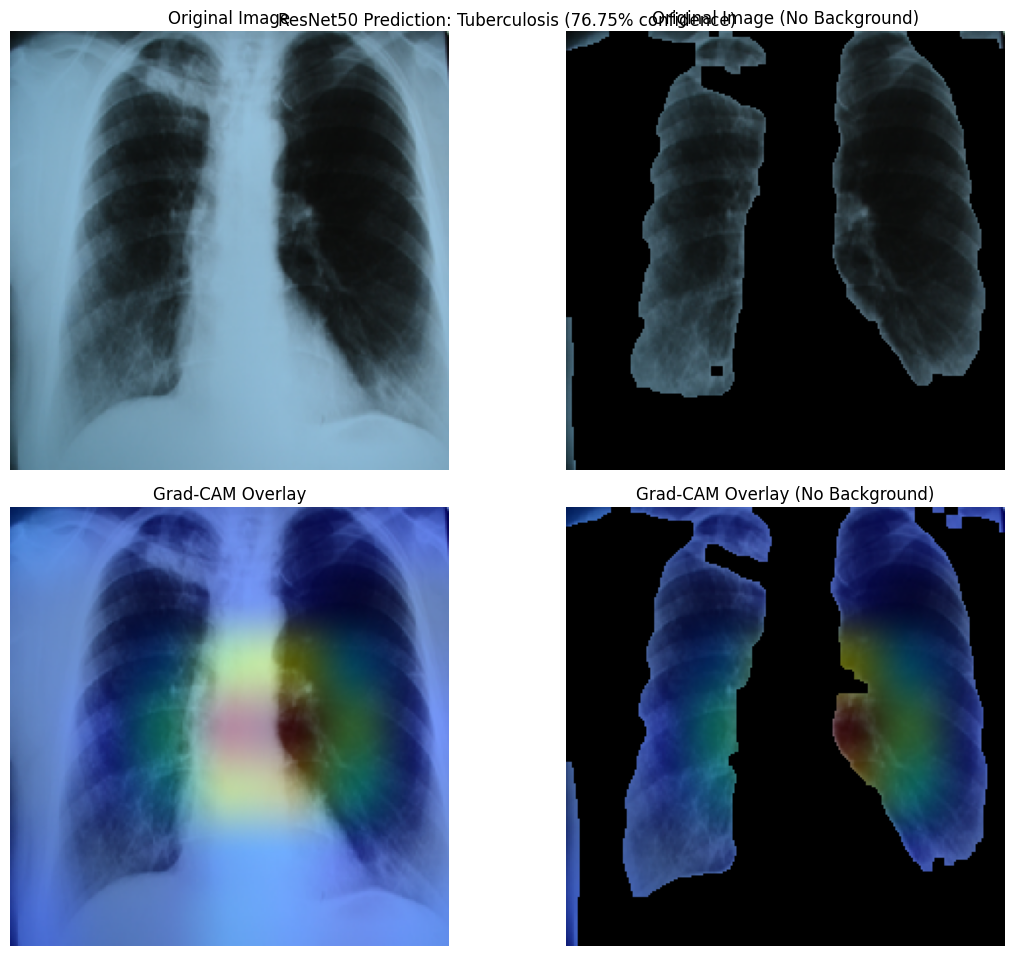

In [7]:
import cv2
import numpy as np
from skimage import filters
from scipy import ndimage

def remove_xray_background(image):
    """
    Remove background from X-ray image using Otsu's thresholding and morphological operations
    """
    # Convert to grayscale if image is RGB
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    else:
        gray = image.copy()
    
    # Apply Gaussian blur to reduce noise
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply Otsu's thresholding
    thresh_val, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    
    # Apply morphological operations to clean up the mask
    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Fill holes in the mask
    mask = ndimage.binary_fill_holes(mask).astype(np.uint8) * 255
    
    # Create an inverted mask for the lungs (assuming lungs are darker)
    lung_mask = cv2.bitwise_not(mask)
    
    # Apply the mask to the original image
    if len(image.shape) == 3:
        lung_mask = cv2.cvtColor(lung_mask, cv2.COLOR_GRAY2RGB)
    
    # Combine original image with mask
    result = cv2.bitwise_and(image, lung_mask)
    
    return result

def predict_with_model_bg_removed(model_name, class_names):
    """
    Predict and visualize results with Grad-CAM and background removal
    """
    # Load model
    model = load_selected_model(model_name)
    
    # Get predictions
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    confidence = predictions[0][predicted_class_index] * 100
    
    # Get last convolutional layer name
    last_conv_layer = get_last_conv_layer(model_name, model)
    
    if last_conv_layer is None:
        raise ValueError(f"Could not find the last convolutional layer for {model_name}")
    
    # Generate Grad-CAM heatmap
    heatmap = generate_gradcam(model, img_array, last_conv_layer)
    
    # Create superimposed visualization
    superimposed_img = create_gradcam_overlay(img_array, heatmap)
    
    # Convert superimposed image to numpy array
    superimposed_array = tf.keras.preprocessing.image.img_to_array(superimposed_img)
    superimposed_array = superimposed_array.astype(np.uint8)
    
    # Remove background from original image
    original_img = (img_array[0] * 255).astype(np.uint8)
    original_no_bg = remove_xray_background(original_img)
    
    # Remove background from Grad-CAM overlay
    gradcam_no_bg = remove_xray_background(superimposed_array)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    
    # Original image
    axes[0, 0].imshow(original_img)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    # Original image without background
    axes[0, 1].imshow(original_no_bg)
    axes[0, 1].set_title('Original Image (No Background)')
    axes[0, 1].axis('off')
    
    # Grad-CAM overlay
    axes[1, 0].imshow(superimposed_img)
    axes[1, 0].set_title('Grad-CAM Overlay')
    axes[1, 0].axis('off')
    
    # Grad-CAM overlay without background
    axes[1, 1].imshow(gradcam_no_bg)
    axes[1, 1].set_title('Grad-CAM Overlay (No Background)')
    axes[1, 1].axis('off')
    
    # Add overall title with prediction and confidence
    plt.suptitle(f'{model_name} Prediction: {predicted_class} ({confidence:.2f}% confidence)', y=0.95)
    plt.tight_layout()
    plt.show()

# Use the new function with background removal
print("Available Models:", list(models.keys()))
model_name = input("Enter the model name to use for prediction (VGG16, VGG19, ResNet50, DenseNet): ").strip()
predict_with_model_bg_removed(model_name, class_names)

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Define the list of models and their respective file paths
models = {
    "VGG16": "vgg16_model.h5",
    "VGG19": "vgg19_model.h5",
    "ResNet50": "resnet50_model.h5",
    "DenseNet": "densenet_model.keras"  # assuming you have DenseNet in .keras format
}

# Function to load the selected model
def load_selected_model(model_name):
    if model_name not in models:
        raise ValueError(f"Invalid model name. Choose from: {list(models.keys())}")
    print(f"Loading model: {model_name}")
    return load_model(models[model_name])

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database\Normal\Normal-14.png"
img = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img_array = np.array(img) / 255.0
img_array = img_array.reshape(1, 224, 224, 3)

# Predict the label using the chosen model
def predict_with_model(model_name, class_names):
    model = load_selected_model(model_name)
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class = class_names[predicted_class_index]
    
    # Print and display the results
    print(f"Predicted Class ({model_name}): {predicted_class}")
    plt.imshow(img)
    plt.title(f"{model_name}: {predicted_class}")
    plt.axis('off')
    plt.show()

# Class names for prediction
class_names = ['Normal', 'Tuberculosis']

# Choose a model and predict
print("Available Models:", list(models.keys()))
model_name = input("Enter the model name to use for prediction (VGG16, VGG19, ResNet50, DenseNet): ").strip()
predict_with_model(model_name, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 556ms/step
Predicted Class (VGG16): Normal


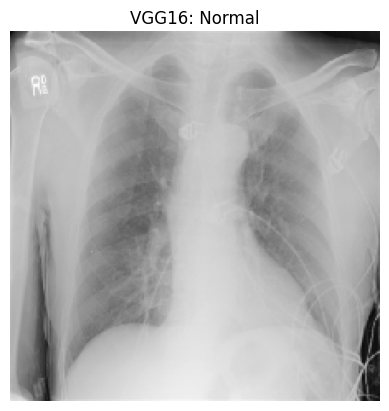

In [30]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the VGG16 model
vgg16_model_path = "vgg16_model.h5"
vgg16_model = load_model(vgg16_model_path)

# Load and preprocess the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Pneumonia (TB) Identification using Explainable AI\TB_Chest_Radiography_Database\Normal\Normal-14.png"
img = image.load_img(image_path, target_size=(224, 224))
img_array = np.array(img) / 255.0
img_array = img_array.reshape(1, 224, 224, 3)

# Predict with VGG16
class_names = ['Normal', 'Tuberculosis']
predictions = vgg16_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the result
print(f"Predicted Class (VGG16): {predicted_class}")
plt.imshow(img)
plt.title(f"VGG16: {predicted_class}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class (ResNet50): Tuberculosis


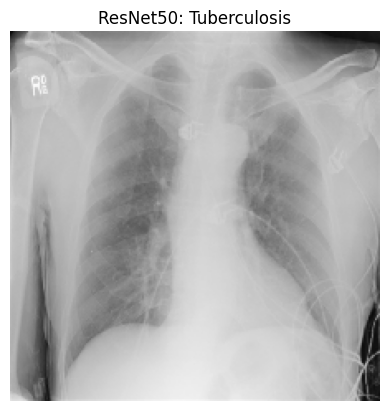

In [31]:
# Load the ResNet50 model
resnet50_model_path = "resnet50_model.h5"
resnet50_model = load_model(resnet50_model_path)

# Predict with ResNet50
predictions = resnet50_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the result
print(f"Predicted Class (ResNet50): {predicted_class}")
plt.imshow(img)
plt.title(f"ResNet50: {predicted_class}")
plt.axis('off')
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted Class (ResNet50): Tuberculosis


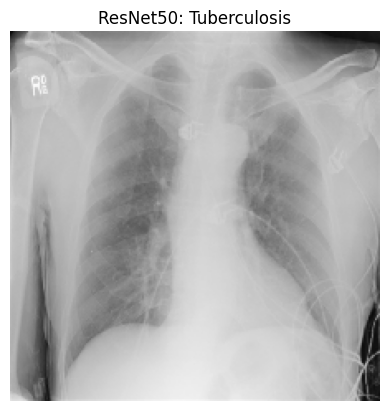

In [32]:
# Load the ResNet50 model
resnet50_model_path = "resnet50_model.h5"
resnet50_model = load_model(resnet50_model_path)

# Predict with ResNet50
predictions = resnet50_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class = class_names[predicted_class_index]

# Display the result
print(f"Predicted Class (ResNet50): {predicted_class}")
plt.imshow(img)
plt.title(f"ResNet50: {predicted_class}")
plt.axis('off')
plt.show()


In [33]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Load the models
vgg16_model = tf.keras.models.load_model('vgg16_model.h5')
resnet50_model = tf.keras.models.load_model('resnet50_model.h5')

# Make predictions for VGG16 model
vgg16_pred = vgg16_model.predict(test_data)
vgg16_pred = vgg16_pred.argmax(axis=1)  # Get class with highest probability

# Make predictions for ResNet50 model
resnet50_pred = resnet50_model.predict(test_data)
resnet50_pred = resnet50_pred.argmax(axis=1)  # Get class with highest probability

# True labels for the test set
test_y = test_data.classes

# Print classification report for VGG16 model
print("Classification Report for VGG16:")
print(classification_report(test_y, vgg16_pred))

# Print classification report for ResNet50 model
print("Classification Report for ResNet50:")
print(classification_report(test_y, resnet50_pred))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Classification Report for VGG16:
              precision    recall  f1-score   support

           0       0.50      0.45      0.48        11
           1       0.67      0.71      0.69        17

    accuracy                           0.61        28
   macro avg       0.58      0.58      0.58        28
weighted avg       0.60      0.61      0.60        28

Classification Report for ResNet50:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        11
           1       0.61      1.00      0.76        17

    accuracy                           0.61        28
   macro avg       0.30      0.50      0.38        28
weighted avg       0.37      0.61      0.46        28



C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the models
vgg16_model = tf.keras.models.load_model('vgg16_model.h5')
resnet50_model = tf.keras.models.load_model('resnet50_model.h5')

# Define the test data generator
test_dir = 'output/test'
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_data = test_datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='categorical')

# Function to preprocess the image
def preprocess_image(model_name, img_array):
    if model_name == "VGG16":
        return tf.keras.applications.vgg16.preprocess_input(img_array)
    elif model_name == "ResNet50":
        return tf.keras.applications.resnet50.preprocess_input(img_array)
    return img_array

# Grad-CAM function
def grad_cam(model, image_array, layer_name="block5_conv3"):
    model = tf.keras.Model(inputs=model.input, outputs=[model.output, model.get_layer(layer_name).output])

    with tf.GradientTape() as tape:
        conv_output, predictions = model(image_array)
        tape.watch(conv_output)
        pred_class = tf.argmax(predictions[0])

    grads = tape.gradient(predictions[0][:, pred_class], conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_output = conv_output[0]
    for i in range(pooled_grads.shape[-1]):
        conv_output[:, :, i] *= pooled_grads[i]

    heatmap = np.mean(conv_output, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap = heatmap / np.max(heatmap)
    return heatmap

# Function to display Grad-CAM results
def display_grad_cam(model_name, model, image_array, heatmap, img):
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=0.6)
    plt.title(f"{model_name} Grad-CAM")
    plt.axis('off')
    plt.show()

# Make predictions and generate classification reports
def make_predictions_and_report(model, model_name):
    pred = model.predict(test_data)
    pred = pred.argmax(axis=1)

    # Generate the classification report
    print(f"Classification Report for {model_name}:")
    print(classification_report(test_data.classes, pred, target_names=test_data.class_indices.keys()))

    # Visualize Grad-CAM for some test images
    for i in range(5):  # Visualizing Grad-CAM for the first 5 test images
        img = test_data[i][0][0]  # Get one image from the test set
        img_array = np.expand_dims(img, axis=0)
        preprocessed_image = preprocess_image(model_name, img_array)

        heatmap = grad_cam(model, preprocessed_image)

        display_grad_cam(model_name, model, img_array, heatmap, img)

# Run for both models
make_predictions_and_report(vgg16_model, "VGG16")
make_predictions_and_report(resnet50_model, "ResNet50")


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ predictions (Dense)             │ (None, 1000)           │     4,097,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 138,357,544 (527.79 MB)

 Trainable params: 138,357,544 (527.79 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


C:\Users\Ajay\anaconda3\envs\py310\lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_67']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


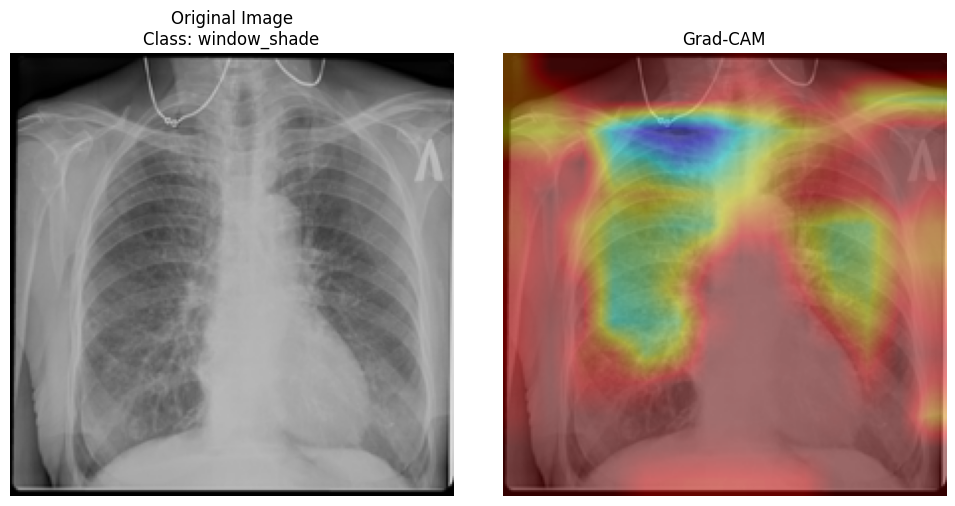

In [3]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2

# Load the pre-trained VGG16 model
vgg16_model = VGG16(weights='imagenet')
vgg16_model.summary()

# Function to preprocess the input image
def preprocess_image(img_path):
    img = load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)  # Preprocess for VGG16
    return img_array

# Function to generate Grad-CAM heatmap
def get_grad_cam_heatmap(model, img_array, class_index, last_conv_layer_name):
    # Get the last convolutional layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Get gradients of the predicted class
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Multiply pooled gradients with convolutional layer output
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Superimpose heatmap on the original image
def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Path to the input image
img_path = r"C:\Users\Ajay\Desktop\Inno_Projects\Pneumonia (TB) Identification\Dataset - Copy\Tuberculosis\Tuberculosis-16.png"  # Replace with your image path
img_array = preprocess_image(img_path)

# Predict the class of the image
predictions = vgg16_model.predict(img_array)
predicted_class_index = np.argmax(predictions)
predicted_class_label = decode_predictions(predictions, top=1)[0][0][1]

# Generate the heatmap for the predicted class
last_conv_layer = "block5_conv3"  # VGG16's last convolutional layer
heatmap = get_grad_cam_heatmap(vgg16_model, img_array, predicted_class_index, last_conv_layer)

# Superimpose the heatmap on the original image
superimposed_img = superimpose_heatmap(img_path, heatmap)

# Display the results
plt.figure(figsize=(10, 5))

# Original Image
plt.subplot(1, 2, 1)
plt.title(f"Original Image\nClass: {predicted_class_label}")
original_img = cv2.imread(img_path)
original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
plt.imshow(cv2.resize(original_img, (224, 224)))
plt.axis('off')

# Grad-CAM Image
plt.subplot(1, 2, 2)
plt.title("Grad-CAM")
plt.imshow(superimposed_img)
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16, VGG19, ResNet50
from tensorflow.keras.applications.vgg16 import preprocess_input as preprocess_vgg16
from tensorflow.keras.applications.resnet50 import preprocess_input as preprocess_resnet50
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import cv2
from tensorflow.keras.applications.vgg16 import decode_predictions

# Load the models
vgg16_model = VGG16(weights='imagenet')
vgg19_model = VGG19(weights='imagenet')
resnet50_model = ResNet50(weights='imagenet')

# Function to preprocess the input image based on the model
def preprocess_image(img_path, model_name):
    img = load_img(img_path, target_size=(224, 224))  # Resize to model input size
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    if model_name == "VGG16" or model_name == "VGG19":
        img_array = preprocess_vgg16(img_array)  # Preprocess for VGG16/VGG19
    elif model_name == "ResNet50":
        img_array = preprocess_resnet50(img_array)  # Preprocess for ResNet50
    return img_array

# Function to generate Grad-CAM heatmap
def get_grad_cam_heatmap(model, img_array, class_index, last_conv_layer_name):
    # Get the last convolutional layer
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )
    
    # Get gradients of the predicted class
    with tf.GradientTape() as tape:
        conv_output, predictions = grad_model(img_array)
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_output = conv_output[0]

    # Multiply pooled gradients with convolutional layer output
    heatmap = conv_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap

# Superimpose heatmap on the original image
def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)
    return superimposed_img

# Path to the input image
img_path = r"C:\Users\Ajay\Desktop\Inno_Projects\Pneumonia (TB) Identification\Dataset - Copy\Tuberculosis\Tuberculosis-16.png"  # Replace with your image path

# Function to predict and visualize Grad-CAM for each model
def visualize_grad_cam(model, model_name):
    img_array = preprocess_image(img_path, model_name)

    # Predict the class of the image
    predictions = model.predict(img_array)
    predicted_class_index = np.argmax(predictions)
    predicted_class_label = decode_predictions(predictions, top=1)[0][0][1]

    # Generate the heatmap for the predicted class
    if model_name == "VGG16" or model_name == "VGG19":
        last_conv_layer = "block5_conv3"  # Last convolutional layer of VGG models
    elif model_name == "ResNet50":
        last_conv_layer = "conv5_block3_3_conv"  # Last convolutional layer of ResNet50
    
    heatmap = get_grad_cam_heatmap(model, img_array, predicted_class_index, last_conv_layer)

    # Superimpose the heatmap on the original image
    superimposed_img = superimpose_heatmap(img_path, heatmap)

    # Display the results
    plt.figure(figsize=(10, 5))

    # Original Image
    plt.subplot(1, 2, 1)
    plt.title(f"Original Image\nClass: {predicted_class_label}")
    original_img = cv2.imread(img_path)
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv2.resize(original_img, (224, 224)))
    plt.axis('off')

    # Grad-CAM Image
    plt.subplot(1, 2, 2)
    plt.title(f"{model_name} Grad-CAM")
    plt.imshow(superimposed_img)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Visualize Grad-CAM for each model
visualize_grad_cam(vgg16_model, "VGG16")
visualize_grad_cam(vgg19_model, "VGG19")
visualize_grad_cam(resnet50_model, "ResNet50")
